# Machine learning to predict Bike Sharing

In [288]:
import os
os.chdir('C:\stuff\Interviews\JDA')
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
import json
from sklearn.metrics import mean_absolute_error, r2_score

In [114]:
#Defining all functions
def convert_to_categorical(data, columns):
    for each in columns:
        data[each] = data[each].astype('category')
        
def calculate_kruskal_wallis(data,column, y_variable = 'cnt'):
    args = [np.array(data.loc[data[column] == value,[y_variable]]) for value in list(data[column].unique())]
    return stats.kruskal(*args).pvalue

In [57]:
data = pd.read_csv('hour.csv')

# EDA

In [4]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Data Explanation
The features we have are: <br>
- instant: record index  (not to be considered while modelling)
- dteday : date
- season : season (1:springe, 2:summer, 3:fall, 4:winter) (Categorical)
- yr : year (0: 2011, 1:2012) (Categorical)
- mnth : month ( 1 to 12) (Categorical)
- hr : hour (0 to 23) (Categorical)
- holiday : weather day is holiday or not (Categorical)
- weekday : day of the week (Categorical)
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0. (Categorical)
+ weathersit : (Categorical)<br> 
  1: Clear, Few clouds, Partly cloudy, Partly cloudy <br>
  2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist <br>
  3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds <br>
  4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog <br>
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale) (Numeric)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale) (Numeric)
- hum: Normalized humidity. The values are divided to 100 (max) (Numeric)
- windspeed: Normalized wind speed. The values are divided to 67 (max) (Numeric)
- casual: count of casual users (Numeric)
- registered: count of registered users (Numeric)
- cnt: count of total rental bikes including both casual and registered (Numeric)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


We have a total of 17379 records. <br>
We see several columns, which we have to convert from Numeric to categorical. <br>
We also see that we don't have any missing values anywhere.

In [59]:
data.set_index('instant', inplace=True)
convert_to_categorical(data, columns = ['season','yr','mnth','hr','holiday','weekday','workingday','weathersit'])

## Null Value Counts

In [60]:
#Null value distribution
data.isnull().sum()

dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

## Numeric Stats Description

In [119]:
#describe
data.describe()

,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


Let's compute correlation matrix, see the heatmap, and pairplot.

## Correlation

In [27]:
corr_mat = round(data.corr(),2)
corr_mat

,temp,atemp,hum,windspeed,casual,registered,cnt
temp,1.00,0.99,-0.07,-0.02,0.46,0.34,0.40
atemp,0.99,1.00,-0.05,-0.06,0.45,0.33,0.40
hum,-0.07,-0.05,1.00,-0.29,-0.35,-0.27,-0.32
windspeed,-0.02,-0.06,-0.29,1.00,0.09,0.08,0.09
casual,0.46,0.45,-0.35,0.09,1.00,0.51,0.69
registered,0.34,0.33,-0.27,0.08,0.51,1.00,0.97
cnt,0.40,0.40,-0.32,0.09,0.69,0.97,1.00


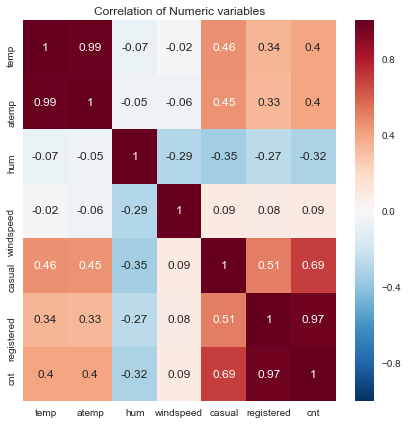

In [210]:
plt.figure(figsize = (7,7))
plt.subplot(1,1,1)
sns.heatmap(corr_mat,annot = True)
plt.title('Correlation of Numeric variables')
sns.plt.show()

## Pairplot

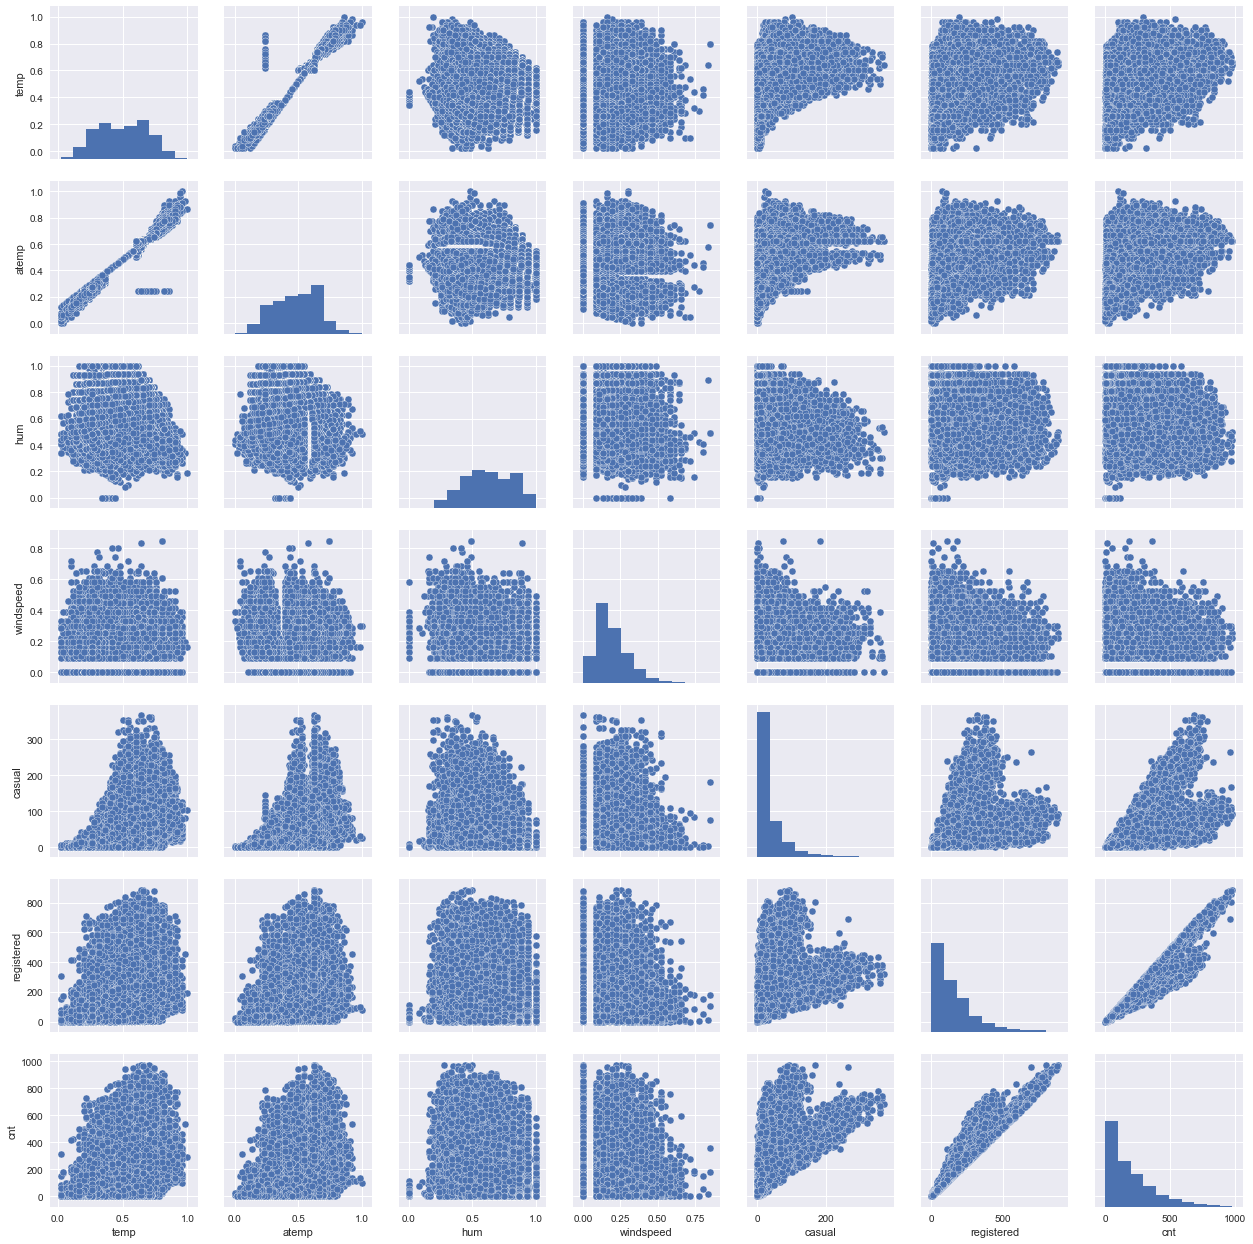

In [34]:
numeric_columns = list(corr_mat.columns)
sns.pairplot(data[numeric_columns])
sns.plt.show()

Based on the above pairplot, we make following observations. <br>
 - We see that none of the numeric features seem to be normally distributed, and most of the features are skewed. <br>
 - We also see that the Y variable (cnt) is most correlated with 'registered'.

Let's see the distribution of Y variable as well.

## Y variable Analysis

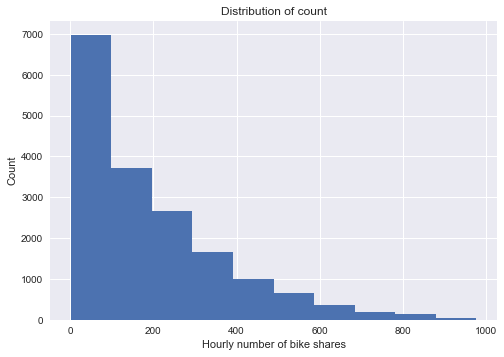

In [91]:
data['cnt'].hist()
plt.title('Distribution of count')
plt.xlabel('Hourly number of bike shares')
plt.ylabel('Count')
plt.show()

We see that the distribution is Right skewed. <br>

Let's do an analysis of Y variable with other categorica features, along the hour.

## Bivariate Analysis

C:\Users\Shyam\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
C:\Users\Shyam\Anaconda3\lib\site-packages\seaborn\categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


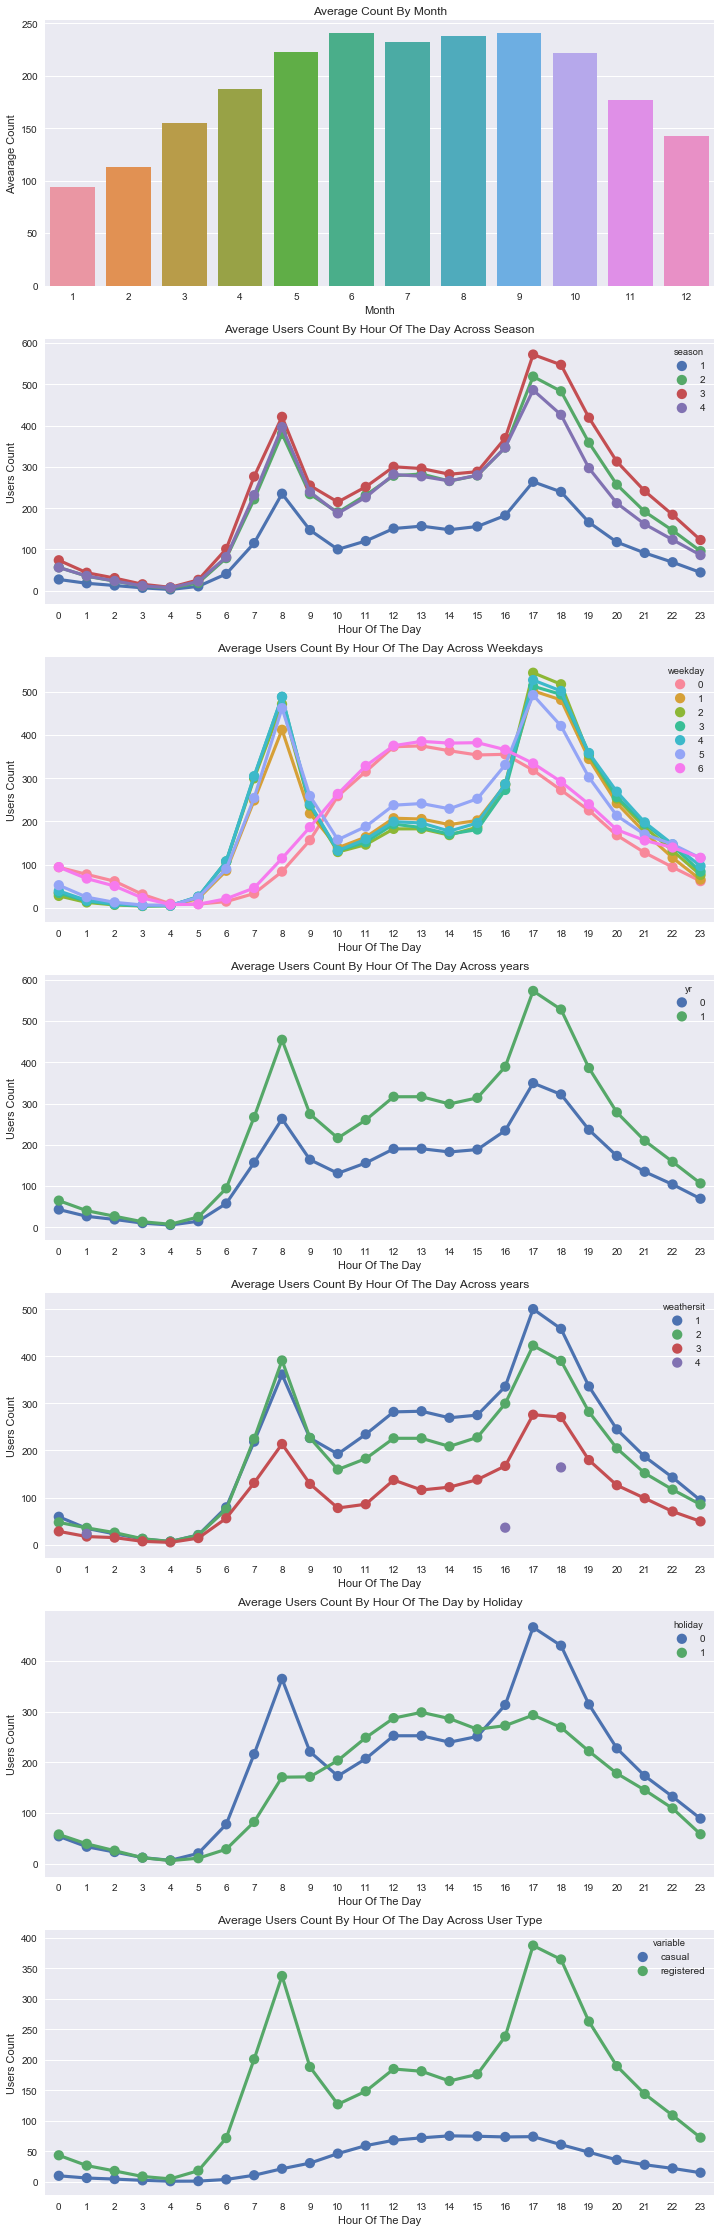

In [118]:
fig,(ax1,ax2,ax3, ax5, ax6, ax7, ax4)= plt.subplots(nrows=7)
fig.set_size_inches(12,40)


monthAggregated = pd.DataFrame(data.groupby("mnth")["cnt"].mean()).reset_index()
#monthSorted = monthAggregated.sort_values(by="cnt",ascending=False)
sns.barplot(data=monthSorted,x="mnth",y="cnt",ax=ax1)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(data.groupby(["hr","season"],sort=True)["cnt"].mean()).reset_index()
sns.pointplot(x="hr", y="cnt",hue="season", data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(data.groupby(["hr","weekday"],sort=True)["cnt"].mean()).reset_index()
sns.pointplot(x="hr", y="cnt",hue="weekday", data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')



hourAggregated = pd.DataFrame(data.groupby(["hr","yr"],sort=True)["cnt"].mean()).reset_index()
sns.pointplot(x="hr", y="cnt",hue="yr", data=hourAggregated, join=True,ax=ax5)
ax5.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across years",label='big')

hourAggregated = pd.DataFrame(data.groupby(["hr","weathersit"],sort=True)["cnt"].mean()).reset_index()
sns.pointplot(x="hr", y="cnt",hue="weathersit", data=hourAggregated, join=True,ax=ax6)
ax6.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weather Situation",label='big')

hourAggregated = pd.DataFrame(data.groupby(["hr","holiday"],sort=True)["cnt"].mean()).reset_index()
sns.pointplot(x="hr", y="cnt",hue="holiday", data=hourAggregated, join=True,ax=ax7)
ax7.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day by Holiday",label='big')

hourTransformed = pd.melt(data[["hr","casual","registered"]], id_vars=['hr'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hr","variable"],sort=True)["value"].mean()).reset_index()
sns.pointplot(x="hr", y="value",hue="variable",hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')


sns.plt.show()

Below, we will see the value counts of weathersit, which has huge imbalance for one category. <br>
We will remove such rows.

In [84]:
#categorical_columns = ['season','yr','mnth','hr','holiday','weekday','workingday','weathersit']
categorical_columns = ['weathersit']
for each in categorical_columns:
    print(data[each].value_counts())

1    11413
2     4544
3     1419
4        3
Name: weathersit, dtype: int64


From the above graphs, the categorical features which seem most important to predict the count are 'hr' and 'mnth'.

Let's see Kruskal Wallis test for each column to see their significance.

In [117]:
categorical_columns = ['season','yr','mnth','hr','holiday','weekday','workingday','weathersit']
for column in categorical_columns:
    print(column + ' ' + str(calculate_kruskal_wallis(data,column, y_variable = 'cnt')))

season 9.47468337305401e-258
yr 9.740282479634629e-165
mnth 4.96487491830795e-270
hr 0.0
holiday 9.929798609529027e-05
weekday 0.00040762429443535927
workingday 0.005558443470312349
weathersit 9.733810896172331e-86


## Important decisions
1. Drop rows with weathersit as 4.
2. Drop columns causal, registered, and dteday.
3. Create index on instant

In [126]:
#Preparing the whole data
data = data.drop(data[data['weathersit'] == 4].index)
data.drop(['dteday','casual','registered'], axis = 1, inplace = True)
data.head(5)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
instant,,,,,,,,,,,,,
1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
2,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
3,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
4,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
5,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


## Modelling with GridSearchCV

 - We see that relatively less features seem important to predict the hourly count. <br>
 - The distribution of explanatory variables are not normal, and Y variable is skewed. <br>
 - Keeping these two things in mind, Lasso Regression seems like a good choice for building Regression model, since it shrinks the weights of the parameters and pretty robust to skewed models. <br>
 - But, we see that correlation is low, and so not much of linear dependence. So, tree models or non parametric models will work best, with ensemble technique. <br>
 - So we can try Gradient boosting and Random forest. <br>
 - We also have big data, so we may be able to try fitting Neural Network for regression purposes.

Keeping these things in mind, we want to mainly try out Neural Network, and tree based algorithm - boosting and bagging.


In [127]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

In [129]:
test_set.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
instant,,,,,,,,,,,,,
6414,4,0,9,19,0,4,1,1,0.62,0.6212,0.50,0.0896,384
14500,3,1,9,8,0,6,0,2,0.76,0.7121,0.58,0.2537,162
1983,2,0,3,11,0,1,1,2,0.26,0.2424,0.30,0.2836,57
12232,2,1,5,20,0,2,1,3,0.70,0.6515,0.61,0.5224,204
432,1,0,1,0,0,4,1,1,0.26,0.2273,0.56,0.3881,13


In [130]:
X_train = train_set.loc[:,train_set.columns != 'cnt']
y_train = train_set['cnt']
#test
X_test = test_set.loc[:,test_set.columns != 'cnt']
y_test = test_set['cnt']


In [205]:
# Selecting categorical or numerical features from dataframe
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, ShuffleSplit
from scipy import stats


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
                           
# Storing results of classification models in a dataframe
results = pd.DataFrame(columns = ["Best tuned model", "Train Accuracy", "Test Accuracy","Train MAE","Test MAE", "Best hyper parameters"])


#Used for p-value testing  
#cv = ShuffleSplit(n_splits = 10, test_size=0.4, random_state=0)

In [206]:
from sklearn.pipeline import Pipeline, FeatureUnion

num_attribs = ['temp', 'atemp', 'hum', 'windspeed']
cat_attribs = ['season','yr','mnth','hr','holiday','weekday','workingday','weathersit']

num_pipeline = Pipeline([
                ('selector', DataFrameSelector(num_attribs)),
                ('imputer', SimpleImputer(strategy= 'median')),
                #('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
            ('selector', DataFrameSelector(cat_attribs)),
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(sparse  = False, handle_unknown = "ignore"))
])


#Combining both the numerical and categorical features pipeline
preparation_pipeline  = FeatureUnion(transformer_list = [('num_pipeline', num_pipeline),
                                                 ('cat_pipeline', cat_pipeline)
                                                 ])

In [279]:
#grid search function
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor

def grid_search_multi_models(X_train, y_train, X_test, y_test, single_regressor = None, parameters_grid_passed = None):
    regressors = [
        ('Linear Regression', LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)),
        ('Lasso Regression', Lasso(fit_intercept=True, normalize=False, copy_X=True, random_state=1)),
        ('Gradient Boost Regressor', GradientBoostingRegressor(random_state = 1)),
        ('Random Forest Regressor', RandomForestRegressor(random_state = 1)),
        ('Neural Networks', MLPRegressor(random_state = 50, activation='relu', max_iter = 100)),
    ]
    
    if single_regressor:
        regressors = single_regressor

    params_grid = {
        'Linear Regression': {},
        'Lasso Regression': {
            'alpha': [0.3,0.5,1.0],
        },
        'Gradient Boost Regressor': {
            'learning_rate':[0.1],
            'n_estimators':[50,70,100],
            'max_depth':[5,10],
        },
        
        'Random Forest Regressor' : {     
            'n_estimators': [50,70,100],
            'max_depth': [5,10],
        },
        
        'Neural Networks': {
            'hidden_layer_sizes': [(10,10),(10,10,10)],
        },
        
    }
    if parameters_grid_passed:
        for each in parameters_grid_passed:
            params_grid[each] = parameters_grid_passed[each]
    
    for (name, regressor) in regressors:
        
        parameters = params_grid[name]

        #preparing th pipeline for estimator

        preparation_pipeline_with_regressor = Pipeline([
        ("preparation", preparation_pipeline),
        ("regressor", regressor)
        ])

        # Perform the grid search for best parameters

        hyper_params = {}
        for params in parameters.keys():
            hyp_p = 'regressor__'+str(params)
            hyper_params[hyp_p] = parameters[params] 
        
        print("Performing Grid Search for", str(name))
        grid_search_clf = GridSearchCV(preparation_pipeline_with_regressor, hyper_params, scoring='neg_mean_absolute_error', n_jobs = -1, cv=5, verbose = 2)
        grid_search_clf.fit(X_train, y_train)
                
        best_train_accuracy = grid_search_clf.best_estimator_.score(X_train, y_train)
        train_mae = mean_absolute_error(np.array(y_train), grid_search_clf.best_estimator_.predict(X_train))
        test_mae = mean_absolute_error(np.array(y_test), grid_search_clf.best_estimator_.predict(X_test))

        best_test_accuracy = grid_search_clf.best_estimator_.score(X_test, y_test)
      
        best_parameters = grid_search_clf.best_estimator_.get_params()
        param_dummy = []
        for param_name in sorted(hyper_params.keys()):
            param_dummy.append((param_name, best_parameters[param_name]))
        
        # Store the results
        results.loc[len(results)] = [name, best_train_accuracy, best_test_accuracy,train_mae,test_mae, json.dumps(param_dummy)]
    if single_regressor:
        return grid_search_clf

In [208]:
%%time
grid_search_multi_models(X_train, y_train, X_test, y_test)

Performing Grid Search for Linear Regression
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


Performing Grid Search for Lasso Regression
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.9s finished


Performing Grid Search for Gradient Boost Regressor
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.4min finished


Performing Grid Search for Random Forest Regressor
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   33.1s finished


Performing Grid Search for Neural Networks
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   14.1s finished


Wall time: 3min 44s


C:\Users\Shyam\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [209]:
pd.set_option('display.max_colwidth', -1)
results

,Best tuned model,Train Accuracy,Test Accuracy,Train MAE,Test MAE,Best hyper parameters
0,Linear Regression,0.686322,0.684805,75.811906,73.795473,[]
1,Lasso Regression,0.683785,0.682160,75.630852,73.830186,"[[""regressor__alpha"", 0.3]]"
2,Gradient Boost Regressor,0.989862,0.926448,12.571981,30.266520,"[[""regressor__learning_rate"", 0.1], [""regressor__max_depth"", 10], [""regressor__n_estimators"", 100]]"
3,Random Forest Regressor,0.810038,0.775654,58.392682,62.583509,"[[""regressor__max_depth"", 10], [""regressor__n_estimators"", 100]]"
4,Neural Networks,0.921758,0.915621,32.993188,33.459383,"[[""regressor__hidden_layer_sizes"", [10, 10, 10]]]"


As predicted, the non parametric models perform better with this dataset. <br>
The Neural Networks is performing good over here, without overfitting to the train data.

But Gradient boost, although overfitting, is performing better. <br>
So let's try gradient boosting, with more number of trees.

## Single model results (Gradient Boosting)

In [280]:
single_regressor =  [('Gradient Boost Regressor', GradientBoostingRegressor(random_state = 1)),]
parameters_grid_passed = {'Gradient Boost Regressor': {
            'learning_rate':[0.1],
            'n_estimators':[100,200],
            'max_depth':[10],
        }}

grid_search_clf = grid_search_multi_models(X_train, y_train, X_test, y_test,single_regressor, parameters_grid_passed)

Performing Grid Search for Gradient Boost Regressor
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.3min finished


In [287]:
grid_search_clf.best_estimator_.get_params()['regressor']

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=10, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=1, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

We see that as we increased the number of trees, the gradient boosting regressor performs better.

In [290]:
y_train_predicted = grid_search_clf.best_estimator_.predict(X_train)
y_test_predicted = grid_search_clf.best_estimator_.predict(X_test)
mae_train = mean_absolute_error(np.array(y_train), y_train_predicted)
mae_test = mean_absolute_error(np.array(y_test), y_test_predicted)
train_r2 = r2_score(y_train, y_train_predicted)
test_r2 = r2_score(y_test, y_test_predicted)

In [291]:
results_single_model = pd.DataFrame(columns = ["Model", "Train R2", "Test R2","Train MAE","Test MAE"])
results_single_model.loc[1] = ['Gradient Boosting', train_r2, test_r2,mae_train,mae_test]

In [292]:
results_single_model

,Model,Train R2,Test R2,Train MAE,Test MAE
1,Gradient Boosting,0.997205,0.92988,6.655456,28.998939


Let's see the scatter plot of Y predicted vs Y actual

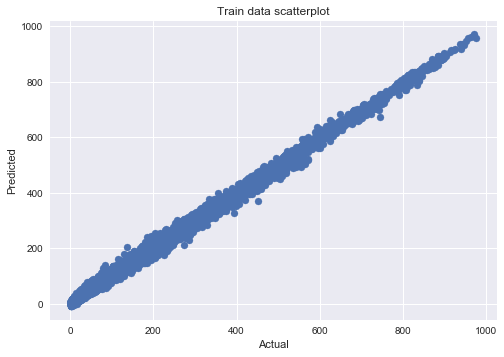

In [294]:
plt.scatter(x = y_train, y = y_train_predicted)
plt.title('Train data scatterplot')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

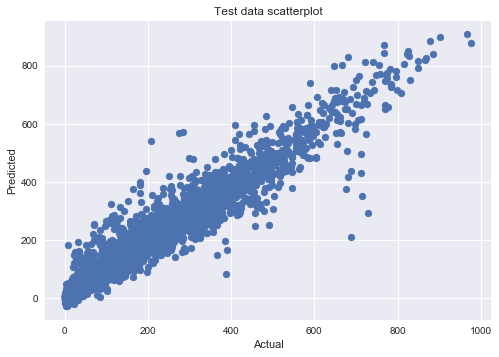

In [295]:
plt.scatter(x = y_test, y = y_test_predicted)
plt.title('Test data scatterplot')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

We see that the test errors are spread lesser than the train errors. <br>
Let's see the histogram of train and test errors.

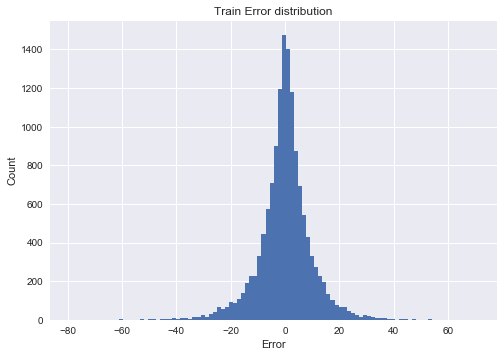

In [298]:
#Histogram of train errors
train_errors = y_train_predicted - y_train
plt.hist(train_errors, bins = 100)
plt.title('Train Error distribution')
plt.xlabel('Error')
plt.ylabel('Count')
plt.show()

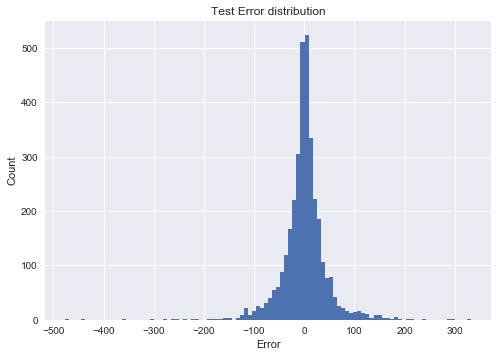

In [299]:
#Histogram of train errors
test_errors = y_test_predicted - y_test
plt.hist(test_errors, bins = 100)
plt.title('Test Error distribution')
plt.xlabel('Error')
plt.ylabel('Count')
plt.show()

We see that errors are normally distributed.